Fixed Source MC code

In [1]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import os

import placzek as pcz

from models import globalvariables as GV
from models import geometry_models as geo_m
from models import physic_model as phy_m
from models import material_model as mat_m
from models import statistic_model as stat_m

from controllers import geometry_controller as geo_c
from controllers import physics_controller as phy_c
from controllers import material_controller as mat_c
from controllers import statistic_controller as stat_c

Import data

In [2]:
PL = 1
LT = 1

# Base directory
base_dir = 'cross_sections_Janis'

# Load data directly with os.path.join
Cnat_total = np.loadtxt(os.path.join(base_dir, 'C', 'Cnat_total.csv'), delimiter=';', skiprows=3)
Cnat_scattering = np.loadtxt(os.path.join(base_dir, 'C', 'Cnat_scattering.csv'), delimiter=';', skiprows=3)

Create isotopes

test 0D

In [3]:
carbon = mat_m.isotope(6,12,1.1E23,Cnat_total[:,0],Cnat_total[:,1],Cnat_total[:,1])
source = phy_m.source(GV.LL,100,GV.SOURCE_POSITION,1.,'fixed')

Create materials

In [4]:
core_list = [carbon]
core = mat_m.material(core_list)
reflector_list = [carbon]
reflector = mat_m.material(reflector_list)

Tally creation

In [5]:
#distribution = [(core,GV.L0,5),(reflector,5,GV.LEnd)]
distribution = [(core,0,GV.LEnd)]
domain = geo_m.domain(distribution,GV.LL,10000,GV.EE,10000,True)
tally = stat_m.tally(GV.LL,200)
avg_rsd = []

Monte Carlo Code

In [6]:
while tally.iter <= GV.Nstories:
    # scelgo la particella da simulare
    nn = phy_c.choose_new_particle(source,1.)
    while nn.eof > 0:
        nn.position = phy_c.sample_free_flight(nn,domain)
        if geo_c.is_outofbound(nn,'space'):
            nn.eof = 0
        else:
            stat_c.count_interaction(tally,nn,domain)
            # aggiorno i dati della particella dopo l'interazione
            nn.energy = phy_c.sample_energy_stepf(nn,domain)
            nn.direction = geo_m.direction.get_rnd_direction()
            nn.weight = phy_c.new_weight(nn,domain)
            # controllo l'energia
            if geo_c.is_outofbound(nn,'energy'):
                nn.eof = 0
            else:
                # russian roulette e splitting
                stat_c.russian_roulette(nn)
                stat_c.splitting(nn)
    stat_c.wellford(tally)
    avg_rsd.append(np.mean(tally.variance))

avg = tally.avg
sigma = tally.RSD
stat_c.normalization(tally)

KeyboardInterrupt: 

plots 0D

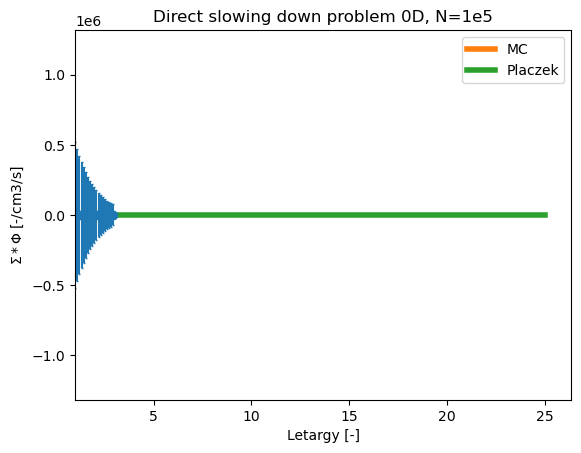

In [ ]:
avg = avg.ravel()
sigma = sigma.ravel()

if LT > 0:
    xx = -np.log(tally.energyref/GV.EREF)
    yy = avg*tally.energyref
    if PL > 0:
        plc = pcz.Lplaczek(12)
else:
    xx = tally.energyref/GV.EREF
    yy = avg
    if PL > 0:
        plc = pcz.adj_placzek(12,domain.materials[0].macro_xs_scattering)
        plc[0] *= 1/GV.EREF

plt.errorbar(xx, yy, yerr=sigma*yy, fmt='o', capsize=1)
plt.plot(xx,yy, linewidth='4' ,label='MC')
if PL > 0:
    plt.plot(plc[0],plc[1],linewidth='4' ,label='Placzek')
if LT > 0:
    plt.xlabel('Letargy [-]')
    plt.ylabel('$\Sigma*\Phi$ [-/cm3/s]')
else:
    plt.xlabel('E/E0 [-]')
    plt.ylabel(r'$\Psi$ [-/cm2/s/eV]')
plt.title('Direct slowing down problem 0D, N=1e5')
plt.xlim(left=1)
plt.legend()
plt.show()

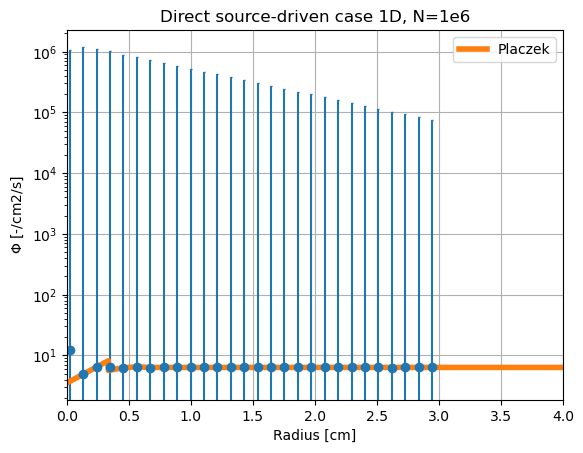

In [ ]:
plt.errorbar(xx, yy, yerr=yy*sigma, fmt='o', capsize=1)
#plt.plot(xx,yy, linewidth='4' ,label='MC')
plt.plot(plc[0],plc[1],linewidth='4' ,label='Placzek')
plt.xlabel('Radius [cm]')
plt.ylabel('$\Phi$ [-/cm2/s]')
plt.title('Direct source-driven case 1D, N=1e6')
plt.yscale('log')
plt.xlim(0,4)
plt.grid()
plt.legend()
plt.show()